In [1]:
import argparse
import pandas as pd
import pickle
import numpy as np
import time
import joblib
from copy import deepcopy
from itertools import combinations
import pymatgen as pym
from pymatgen.core import Composition

import shap

import sklearn
from sklearn.metrics import mean_squared_error,mean_absolute_error,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
prop_cycle = plt.rcParams['axes.prop_cycle']
DEFAULT_COLORS = prop_cycle.by_key()['color']
plt.rc('text', usetex=True)
plt.rc('font', **{'size':8})

# Cleaning/preparing Miracle dataset

In [2]:
def remove_class(df,remove):

    origsize = len(df)

    resetindices = [i for i in range(origsize)]
    df.index = resetindices

    remove_inds = df.index[df['SS or IM']==remove].tolist()

    df.drop(remove_inds,inplace=True)
    
    newsize = len(df)

    print("Removed '%s' from dataset: %d -> %d entries"%(remove,origsize,newsize))

def clean_duplicate_phases(df, verbose=False):
    """
    Can only have one phase label per composition, but the database reports
    that different synthesis techniques yield different phases for the same composition

    For now, if multiple entries for a given composition and at least one of them
    has a label of SS, then we assume the composition can be made in SS and assign it that label
    """

    print("Cleaning duplicate phases:")

    df.fillna(method='ffill',inplace=True)
    duplicates = df[df.duplicated(subset='Composition_Formula')]
    unique_compositions = set(duplicates['Composition_Formula'])

    final_delete = []
    final_dups = []
    
    for comp in unique_compositions:

        
        dup_indices = df.index[df['Composition_Formula'] == comp].tolist()
        final_dups += dup_indices

        allphases = np.array(df['SS or IM'])[dup_indices]
        upperphases = [phase.upper() for phase in allphases]
        uniquephases = set(upperphases)

        if 'SS' in upperphases:
            thisphase = 'SS'
        elif 'SS+IM' in upperphases:
            thisphase = 'SS+IM'
        elif 'IM' in upperphases:
            thisphase = "IM"
        else:
            thisphase = "UNK"

        if len(uniquephases) != 1:
            if verbose:
                print("%s contains multiple experimentally reported phases: %s"%\
                      (comp, uniquephases))
                print("Assigned phase: %s"%(thisphase))


        tokeepind = dup_indices[0]
        # Should prob switch this to .loc instead of .iloc
        df.iloc[tokeepind, df.columns.get_loc('SS or IM')] = thisphase

        final_delete+=dup_indices[1:]

    df = df.drop(final_delete)

    print("Final classes:")
    print("Num SS: %d"%len(df.index[df['SS or IM'] == 'SS']))
    print("Num SS+IM: %d"%len(df.index[df['SS or IM'] == 'SS+IM']))
    print("Num IM: %d"%len(df.index[df['SS or IM'] == 'IM']))
    
    return df

# ML Routines

In [3]:
def magpie_featurize_data(df,comp_col='Composition_Formula',
                             keep_comp_col = False,
                             keep_cols=[]):
    origcols = set(df.columns)
        
    df = StrToComposition(target_col_id='composition_obj').\
                      featurize_dataframe(df, comp_col)

    feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                              cf.ElementProperty.from_preset("magpie"),
                                              cf.ValenceOrbital(props=['avg']), 
                                              cf.IonProperty(fast=True)])

    feature_labels = feature_calculators.feature_labels()

    df = feature_calculators.featurize_dataframe(df,col_id='composition_obj')

    #df.columns = [col.replace('_','\_') for col in df.columns]
    df.columns = [col.replace('MagpieData','') for col in df.columns]
    df.columns = [col.replace('average','mu') for col in df.columns]
    df.columns = [col.replace('maximum','max') for col in df.columns]
    df.columns = [col.replace('minimum','min') for col in df.columns]
    
    if keep_comp_col:
        origcols.remove(comp_col)
    
    for elem in keep_cols:
        try:
            origcols.remove(elem)
        except:
            pass
    
    features = df.drop(list(origcols)+['composition_obj'],
                       axis=1,inplace=False)
    
    return features

def get_train_test_split(X, y, test_size, random_state):

    X_train, X_test, y_train, y_test =\
        train_test_split(X, y,test_size = test_size,
                         random_state = random_state)

    return X_train, X_test, y_train, y_test


def get_kfold(X, nsplits, shuffle=True, random_state=0):

    print(nsplits)
    kf = KFold(n_splits=nsplits, shuffle=shuffle, random_state=random_state)
    kf.get_n_splits(X)

    return kf

def data_splits_and_transform(df, features):
    
    # 1. Training data/labels
    X = np.array(features,dtype='float')
    ally = np.array(df['SS or IM']).reshape(-1,1)
    
    # 2. Encoding of each class
    enc = sklearn.preprocessing.OrdinalEncoder()
    enc.fit(ally)
    y = enc.transform(ally)
    print(enc.categories_)

    # 3. set up the k-fold validation
    seed = 1
    test_size = 0.2
    nsplits =int(np.ceil(1/test_size))
    kf = get_kfold(X, nsplits, True, seed)
    
    # 4. For storing averged feature importances
    all_feature_importance = np.zeros(np.shape(features)[1])

    return X, y, kf, all_feature_importance, enc

def fit_model(X, y, kf, param, verbose=False):

    all_accuracies = []
    all_estimators = []
    all_reports = []
    kfold = 0
    for train_index,test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = np.ravel(y[train_index]), np.ravel(y[test_index])

        est = GradientBoostingClassifier(**param).fit(X_train, y_train)
        all_estimators.append(est)

        # https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
        score = est.score(X_test, y_test)
        all_accuracies.append(score)
        
        classification_report = sklearn.metrics.classification_report(\
                                    y_test, est.predict(X_test))
        all_reports.append(classification_report)

        if verbose:
            print("kfold %d score: %.2f"%(kfold,score))
            print(classification_report)

        kfold+=1
        
    return all_estimators, all_accuracies, all_reports
    
def hpopt_objective(param):
    all_estimators, all_accuracies, all_reports =\
        fit_model(X_HPopt, y_HPopt, kf_HPopt, param)
    return -np.mean(all_accuracies)

def fit_final_model(X, y, param):
    
    est = GradientBoostingClassifier(**param).fit(X, y)
    return est

def fit_model_with_HPopt(X, y, kf):

    from hyperopt import tpe, Trials, fmin, hp

    space = {
        'n_estimators':     hp.choice('n_estimators', np.arange(10, 200, 1, dtype=int)),
        'learning_rate':    hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)),
        'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
        'subsample':        hp.uniform('subsample', 0.8, 1),
        'random_state':     10,
        'n_iter_no_change': None,}
    
    # Super hacky but not sure how else to handle this w/o
    # having to go back and redo stuff on account of fmin not
    # taking fixed parameters
    global X_HPopt
    X_HPopt = deepcopy(X)
    global y_HPopt
    y_HPopt = deepcopy(y)
    global kf_HPopt
    kf_HPopt = deepcopy(kf)

    tpe_trials = Trials()
    tpe_algo = tpe.suggest
    tpe_best = fmin(fn=hpopt_objective, space=space, algo=tpe_algo, 
                    trials=tpe_trials, max_evals=10)

    return tpe_best

def optimize_GBR_classifier(df,features,HPopt=False):
    
    X, y, kf, all_feature_importance, enc = data_splits_and_transform(df,features)
    
    # Manually storing optimal parameters from prev experiment
    bestparams = {'n_estimators'  : 100,
                  'learning_rate' : 0.01,
                  'max_depth'     : 8,
                  'subsample'     : 0.75,
                  'random_state'  : 10,
                  'n_iter_no_change': None,}
    
    # {'learning_rate': 0.00468703569796412, 'max_depth': 7, 'n_estimators': 101, 'subsample': 0.9026543781551416}
    
    # Redo optimal hyperparameter search if desired
    if HPopt:
        bestparams = fit_model_with_HPopt(X, y, kf)
        print("Best hyperparameters:")
        print(bestparams)

    all_estimators, all_accuracies, all_reports =\
        fit_model(X, y, kf, bestparams,verbose=True)
    
    final_model = fit_final_model(X, y, bestparams)
    
    view_model_performance(X, y, kf, bestparams, all_estimators, df)
    
    return final_model, all_estimators, all_accuracies, all_reports, enc

def view_model_performance(X, y, kf, param, all_estimators, df, verbose = False):

    ncols=4
    nsplits = len(list(kf.split(X)))
    fig, axs = plt.subplots(nrows=nsplits,ncols=2,
                           figsize=(6,1.5*nsplits),
                           gridspec_kw={'width_ratios': [3,1]})

    it=0
    all_feature_importance = np.zeros(np.shape(X)[1])
    for (train_index,test_index), est in zip(kf.split(X),all_estimators):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = np.ravel(y[train_index]), np.ravel(y[test_index])

        # staged predicition for learning curves
        test_score = np.zeros((param['n_estimators'],), dtype=np.float64)
        for i, y_pred in enumerate(est.staged_predict(X_test)):
            score = sklearn.metrics.accuracy_score(y_test, y_pred.ravel(), sample_weight=None)
            test_score[i] = score

        # Final classification report
        classification_report = sklearn.metrics.classification_report(\
                                    y_test, est.predict(X_test).ravel())
        if verbose:
            print(classification_report)

        # Plot staged predicitions
        ax = axs[it,0]
        ax.plot(np.arange(param['n_estimators']) + 1, est.train_score_, 'b-',
                label='Training Set Mean Accuracy')
        axtwin = ax.twinx()
        axtwin.plot(np.arange(param['n_estimators']) + 1, test_score, 'r-',
                   label='Test Set Mean Accuracy')
        ax.set_xlabel('Boosting Iterations')
        ax.set_ylabel('Training Set Deviance')
        axtwin.set_ylabel('Test Set Accuracy')


        # feature importances
        feature_importance = est.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        all_feature_importance += feature_importance
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        maxdisplay = min(len(pos),8) # we only want to plot a max num of features

        ax = axs[it,1]

        ax.barh(pos[-maxdisplay:], feature_importance[sorted_idx][-maxdisplay:], 
                      align='center')
        ax.set_yticks(pos[-maxdisplay:])
        ticklabels = [feature.replace('_','\_')\
                      for feature in features.columns[sorted_idx][-maxdisplay:]]
        ax.set_yticklabels(ticklabels)
        ax.set_xlabel('Relative Importance')
        ax.set_xlim((0,100))

        it+=1

    plt.tight_layout(pad=0.1)
    plt.savefig('figures/GBT_phase_predict_train.png',dpi=300) 
    plt.show()

# Train/Evaluate GBT model

In [4]:
df = pd.read_csv('data/HEA_phase_data.csv')
dfclean = clean_duplicate_phases(df)
remove_class(dfclean,'Unk')

Cleaning duplicate phases:
Final classes:
Num SS: 182
Num SS+IM: 169
Num IM: 49
Removed 'Unk' from dataset: 405 -> 400 entries


In [5]:
features = magpie_featurize_data(dfclean)

StrToComposition:   0%|          | 0/400 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/400 [00:00<?, ?it/s]

[array(['IM', 'SS', 'SS+IM'], dtype=object)]
5
kfold 0 score: 0.76
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         9
         1.0       0.70      0.88      0.78        34
         2.0       0.81      0.68      0.74        37

    accuracy                           0.76        80
   macro avg       0.83      0.74      0.77        80
weighted avg       0.78      0.76      0.76        80

kfold 1 score: 0.78
              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57        10
         1.0       0.80      0.80      0.80        35
         2.0       0.73      0.86      0.79        35

    accuracy                           0.78        80
   macro avg       0.84      0.69      0.72        80
weighted avg       0.80      0.78      0.77        80

kfold 2 score: 0.76
              precision    recall  f1-score   support

         0.0       1.00      0.38      0.55         8
         1.0       0.7

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


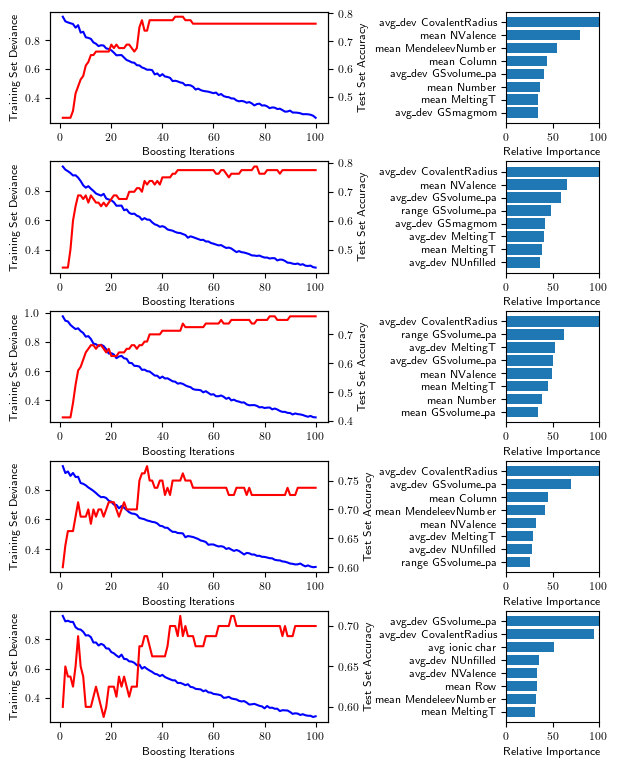

In [6]:
final_model, all_estimators, all_accuracies, all_reports, enc =\
    optimize_GBR_classifier(dfclean,features,HPopt=False)

In [9]:
import joblib
joblib.dump(final_model,'HEA_phase_estimator.joblib')

['HEA_phase_estimator.joblib']

In [7]:
np.mean(all_accuracies)

0.7474999999999999

In [8]:
dfclean.to_csv('data/cleaned_HEA_phase_data.csv')
features.to_csv('data/cleaned_HEA_phase_features.csv')

In [9]:
newdf = magpie_featurize_data(dfclean, keep_comp_col=True, keep_cols=['SS or IM'])

In [10]:
newdf.to_csv('data/cleaned_HEA_phase_data_features.csv')

In [11]:
newdf

,Composition_Formula,SS or IM,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,min Number,max Number,...,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,AgAlCoCrCuNi,SS+IM,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,47.0,...,220.500000,8.833333,194.0,1.500000,0.166667,6.666667,0.000000,False,0.025275,0.004117
1,AlAuCoCrCuNi,SS+IM,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,79.0,...,220.500000,8.833333,194.0,1.500000,0.166667,6.666667,2.333333,False,0.194446,0.021371
2,AlCoCrCu0.5Fe,SS+IM,5,0.458123,0.356393,0.293681,0.270967,0.255273,13.0,29.0,...,219.888889,11.506173,194.0,1.666667,0.222222,5.111111,0.000000,False,0.020806,0.003396
3,AlCoCrCuFe,SS+IM,5,0.447214,0.341995,0.275946,0.251700,0.234924,13.0,29.0,...,220.400000,10.560000,194.0,1.600000,0.200000,5.600000,0.000000,False,0.020806,0.003480
4,AlCoCrCuFeMnNi,SS+IM,7,0.377964,0.273276,0.210825,0.188638,0.173545,13.0,29.0,...,220.571429,8.612245,194.0,1.714286,0.142857,5.857143,0.000000,False,0.031881,0.004874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,CuFeHfTiZr,SS,5,0.447214,0.341995,0.275946,0.251700,0.234924,22.0,72.0,...,207.200000,15.840000,194.0,1.800000,0.000000,4.400000,2.800000,False,0.086069,0.014875
401,CuHfNiTiZr,SS,5,0.447214,0.341995,0.275946,0.251700,0.234924,22.0,72.0,...,206.400000,14.880000,194.0,1.800000,0.000000,4.800000,2.800000,False,0.088829,0.016984
402,FeMnNi,SS,3,0.577350,0.480750,0.415244,0.389977,0.372041,25.0,28.0,...,223.666667,4.444444,217.0,2.000000,0.000000,6.333333,0.000000,False,0.031881,0.005877
403,MoPdRhRu,SS,4,0.500000,0.396850,0.329877,0.304753,0.287175,42.0,46.0,...,218.250000,12.125000,194.0,0.750000,0.000000,7.500000,0.000000,False,0.003594,0.000474


# Analyze on the "hold-out" rHEA combinations

In [12]:
# which hypothetical dataset we are dealing with
#hypset = 'r3dHEA' 
hypset = 'allHEA'

### 1. Customized sklearn confusion matrix plotting

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_pred, y_true, labels, *,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='viridis', ax=None):
    """Plot Confusion Matrix.
    Read more in the :ref:`User Guide <confusion_matrix>`.
    Parameters
    ----------
    estimator : estimator instance
        Fitted classifier or a fitted :class:`~sklearn.pipeline.Pipeline`
        in which the last estimator is a classifier.
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Input values.

    y : array-like of shape (n_samples,)
        Target values.
    labels : array-like of shape (n_classes,), default=None
        List of labels to index the matrix. This may be used to reorder or
        select a subset of labels. If `None` is given, those that appear at
        least once in `y_true` or `y_pred` are used in sorted order.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    normalize : {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    display_labels : array-like of shape (n_classes,), default=None
        Target names used for plotting. By default, `labels` will be used if
        it is defined, otherwise the unique labels of `y_true` and `y_pred`
        will be used.
    include_values : bool, default=True
        Includes values in confusion matrix.
    xticks_rotation : {'vertical', 'horizontal'} or float, \
                        default='horizontal'
        Rotation of xtick labels.
    values_format : str, default=None
        Format specification for values in confusion matrix. If `None`,
        the format specification is 'd' or '.2g' whichever is shorter.
    cmap : str or matplotlib Colormap, default='viridis'
        Colormap recognized by matplotlib.
    ax : matplotlib Axes, default=None
        Axes object to plot on. If `None`, a new figure and axes is
        created.
    Returns
    -------
    display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
    Examples
    --------
    >>> import matplotlib.pyplot as plt  # doctest: +SKIP
    >>> from sklearn.datasets import make_classification
    >>> from sklearn.metrics import plot_confusion_matrix
    >>> from sklearn.model_selection import train_test_split
    >>> from sklearn.svm import SVC
    >>> X, y = make_classification(random_state=0)
    >>> X_train, X_test, y_train, y_test = train_test_split(
    ...         X, y, random_state=0)
    >>> clf = SVC(random_state=0)
    >>> clf.fit(X_train, y_train)
    SVC(random_state=0)
    >>> plot_confusion_matrix(clf, X_test, y_test)  # doctest: +SKIP
    >>> plt.show()  # doctest: +SKIP
    """
    #check_matplotlib_support("plot_confusion_matrix")

    assert len(y_pred) == len(y_true)
    #else: 
    #    raise ValueError("Custom plot_confusion_matrix only supports direct passing of y_predict")

    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

### 1. Prepare summary of GBT vs AWE-ML Predictions

In [15]:
# rHEA features (w/Composition label)
df_rHEA = pd.read_csv('data/%s_features.csv'%hypset,index_col=0)

# features only
df_rHEA_fea = df_rHEA.drop('Composition_Formula',axis=1)

# rHEA predictions
rHEA_predict_GBT = final_model.predict(df_rHEA_fea)

df_rHEA['GBTPredict'] = rHEA_predict_GBT

print('data/%s_phase_data_final.csv'%hypset)
df_rHEA[['Composition_Formula','GBTPredict']].to_csv('data/%s_phase_data_final.csv'%hypset)

data/allHEA_phase_data_final.csv


In [ ]:
# # rHEA features (w/Composition label)
# df_rHEA = pd.read_csv('data/%s_features.csv'%hypset,index_col=0)

# # features only
# df_rHEA_fea = df_rHEA.drop('Composition_Formula',axis=1)

# # rHEA predictions
# rHEA_predict_GBT = final_model.predict(df_rHEA_fea)

# # AWE-ML predictions for comparison
# df_rHEA_predict_AWEML = pd.read_csv('data/%s_phase_data_AWEML.csv'%hypset,index_col=0)
# df_rHEA_predict_AWEML['prediction'] = enc.transform(np.array(df_rHEA_predict_AWEML['prediction'])[..., None])

# # Final table of both predictions
# df_final = pd.concat((df_rHEA['Composition_Formula'], pd.DataFrame(rHEA_predict_GBT,columns=['GBTPredict'])),axis=1)
# df_final = df_final.merge(df_rHEA_predict_AWEML[['material','prediction']],
#                           left_on='Composition_Formula',right_on='material')
# df_final = df_final.drop('material', axis=1)
# df_final = df_final.rename({'prediction':'AWEMLPredict'},axis=1)

### 2. Confusion matrix plots between AWE-ML and GBT

In [ ]:
# a = df_final['GBTPredict']
# b = df_final['AWEMLPredict']
# df_final['Composition'] = [Composition(c) for c in df_final['Composition_Formula']]

# fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(2.7,3.5),constrained_layout=True)
# plot_confusion_matrix(b, a, labels=[0,1,2],
#                       display_labels=[r'$\textrm{IM}$',r'$\textrm{SS}$',r'$\textrm{SS+IM}$'],
#                       cmap=plt.cm.Blues,ax=axs[0],normalize='all')
# #axs[0].set_xlabel(r'$\textrm{AWE-ML Prediction}$')
# axs[0].set_xlabel(None)
# axs[0].set_ylabel(r'$\textrm{GBT Prediction}$')
# axs[0].text(-2,-0.25,r"\textrm{(a)}",fontsize=11)

# # manual entry of predictions for experimentally validated compounds
# prev_experiment = ["VTiCrMo","VTiCrNbMo","VTiCrNb","VTiTaCrNb","VTiTaNb","TiZrTaNbHf",
#                    "VTiNbHf","VTiZrNb","TiZrNbHf","VTiZrNbHf"]

# GBTexpclass = []
# AWEMLexpclass = []
# for comp in prev_experiment:
#     GBTexpclass.append(int(df_final.loc[df_final['Composition'] == Composition(comp), 'GBTPredict']))
#     AWEMLexpclass.append(int(df_final.loc[df_final['Composition'] == Composition(comp), 'AWEMLPredict']))

# plot_confusion_matrix(AWEMLexpclass, GBTexpclass, labels=[0,1,2],
#                       display_labels=[r'$\textrm{IM}$',r'$\textrm{SS}$',r'$\textrm{SS+IM}$'],
#                       cmap=plt.cm.Blues,ax=axs[1],normalize='all')
# axs[1].set_xlabel(r'$\textrm{AWE-ML Prediction}$')
# axs[1].set_ylabel(r'$\textrm{GBT Prediction}$')
# axs[1].text(-2,-0.25,r"\textrm{(b)}",fontsize=11)


# plt.savefig('figures/%s_phase_pred_cm.pdf'%)

# plt.show()

In [ ]:
#print(df_final)

In [ ]:
#df_final.loc[df_final['Composition']==Composition('TiVZrHf')]

In [ ]:
#df_final.to_csv('data/%s_phase_data_final.csv'%hypset)